In [ ]:
# !pip install rio-tiler
! pip install ipyleaflet
# !pip install matplotlib

In [1]:
import datetime
import json

import httpx
import morecantile
import numpy
from ipyleaflet import GeoJSON, Map, basemaps
from matplotlib.pyplot import figure
from rasterio.features import bounds as featureBounds

from rio_tiler.io import Reader, STACReader
from rio_tiler.models import ImageData
from rio_tiler.mosaic import mosaic_reader
from rio_tiler.mosaic.methods import defaults
from rio_tiler.mosaic.methods.base import MosaicMethodBase

In [2]:
stac_endpoint = "https://earth-search.aws.element84.com/v0/search"

In [3]:
# use geojson.io
geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [30.810813903808594, 29.454247067148533],
                        [30.88600158691406, 29.454247067148533],
                        [30.88600158691406, 29.51879923863822],
                        [30.810813903808594, 29.51879923863822],
                        [30.810813903808594, 29.454247067148533],
                    ]
                ],
            },
        }
    ],
}

bounds = featureBounds(geojson)

In [4]:
# Date filter
date_min = "2019-06-01"
date_max = "2019-09-01"

start = datetime.datetime.strptime(date_min, "%Y-%m-%d").strftime("%Y-%m-%dT00:00:00Z")
end = datetime.datetime.strptime(date_max, "%Y-%m-%d").strftime("%Y-%m-%dT23:59:59Z")

query = {
    "collections": [
        "sentinel-s2-l2a-cogs"
    ],  # Make sure to query only sentinel-2 COGs collection
    "datetime": f"{start}/{end}",
    "query": {"eo:cloud_cover": {"lt": 5}},  # Use low cloud cover
    "intersects": geojson["features"][0]["geometry"],
    "limit": 1000,
    "fields": {
        "include": [
            "id",
            "properties.datetime",
            "properties.eo:cloud_cover",
        ],  # Make returned response ligth
        "exclude": ["links"],
    },
}

headers = {
    "Content-Type": "application/json",
    "Accept-Encoding": "gzip",
    "Accept": "application/geo+json",
}


data = httpx.post(stac_endpoint, headers=headers, json=query).json()
print(data["context"])
print()
print("Example:")
print(json.dumps(data["features"][0], indent=4))

sceneid = [f["id"] for f in data["features"]]
cloudcover = [f["properties"]["eo:cloud_cover"] for f in data["features"]]
dates = [f["properties"]["datetime"][0:10] for f in data["features"]]

# For this demo we will use the True color image `TCI` asset
assets = [f["assets"]["visual"]["href"] for f in data["features"]]

{'page': 1, 'limit': 1000, 'matched': 23, 'returned': 23}

Example:
{
    "assets": {
        "overview": {
            "proj:shape": [
                343,
                343
            ],
            "proj:transform": [
                320,
                0,
                199980,
                0,
                -320,
                3300000,
                0,
                0,
                1
            ],
            "href": "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/R/TT/2019/8/S2B_36RTT_20190830_0_L2A/L2A_PVI.tif",
            "title": "True color image",
            "type": "image/tiff; application=geotiff; profile=cloud-optimized"
        },
        "thumbnail": {
            "href": "https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/36/R/TT/2019/8/30/0/preview.jpg",
            "title": "Thumbnail",
            "type": "image/png"
        },
        "metadata": {
            "href": "https://roda.sentinel-hub.com/sentinel-s2-l2a/til

In [5]:
m = Map(
    basemap=basemaps.OpenStreetMap.Mapnik,
    center=((bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2),
    zoom=8,
)

# add scenes
geo_json = GeoJSON(
    data=data,
    style={"opacity": 1, "dashArray": "1", "fillOpacity": 0, "weight": 1},
)
m.add_layer(geo_json)

# add AOI
geo_json = GeoJSON(
    data=geojson,
    style={"opacity": 1, "dashArray": "1", "fillOpacity": 1, "weight": 1},
)
m.add_layer(geo_json)

m

Map(center=[29.486523152893376, 30.848407745361328], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [6]:
def tiler(asset, *args, **kwargs):
    with Reader(asset) as src:
        return src.tile(*args, **kwargs)

In [7]:
# List of z12 mercator tiles
tms = morecantile.tms.get("WebMercatorQuad")

tiles = list(tms.tiles(*bounds, 12))
print(len(tiles))

4


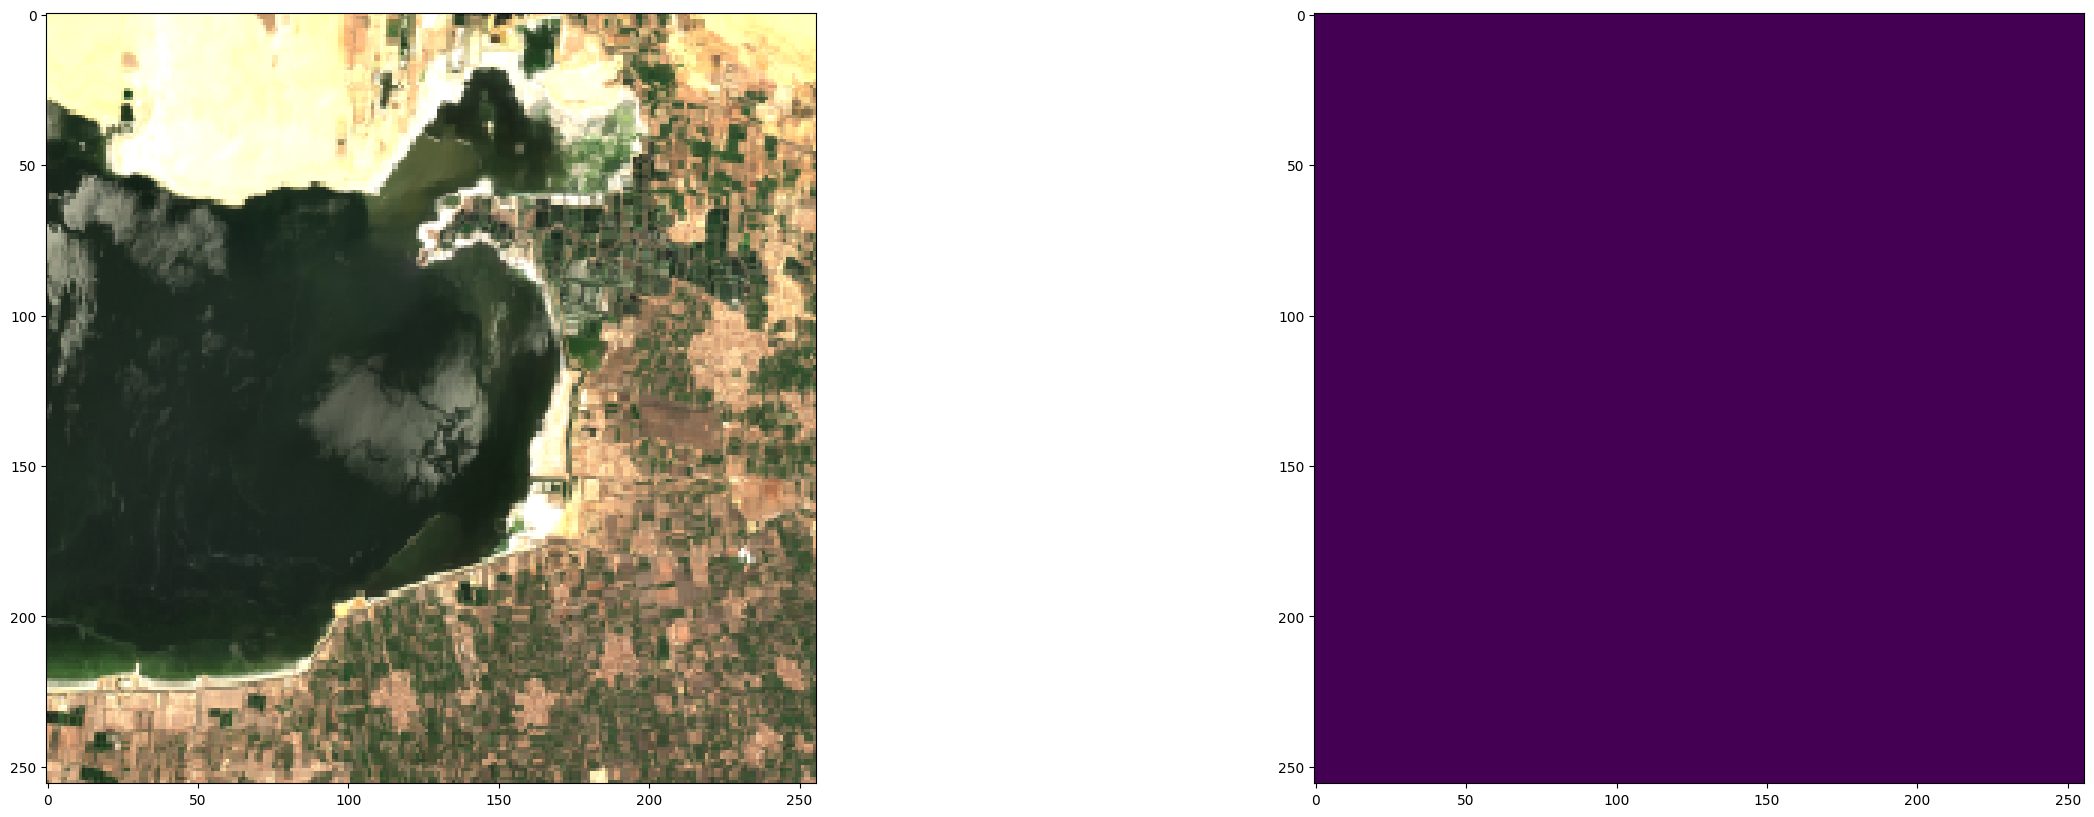

In [8]:
tile = tiles[0]

img, assets_used = mosaic_reader(
    assets,
    tiler,
    tile.x,
    tile.y,
    tile.z,
    threads=1,
)

fig = figure(figsize=(30, 10))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img.data_as_image())

ax = fig.add_subplot(1, 2, 2)
ax.imshow(img.mask)

In [9]:
print(len(assets_used))
print(assets_used)

1
['https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/R/TT/2019/8/S2B_36RTT_20190830_0_L2A/TCI.tif']


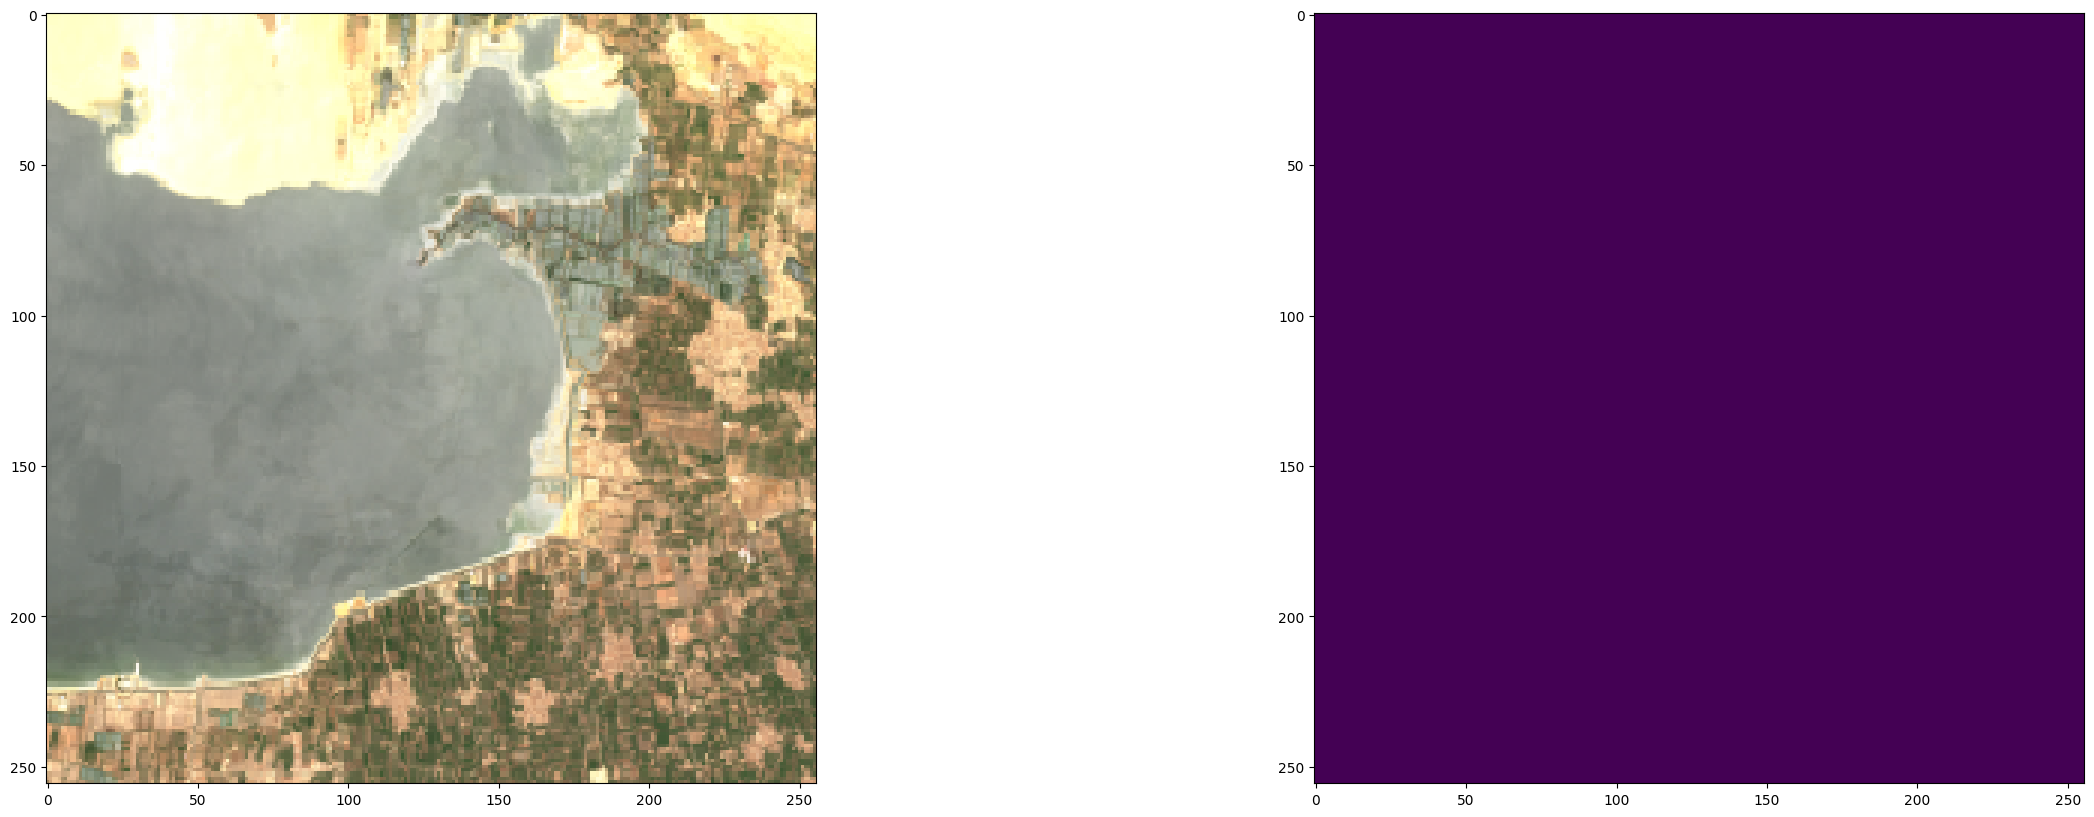

In [10]:
tile = tiles[0]

img, assets_used = mosaic_reader(
    assets,
    tiler,
    tile.x,
    tile.y,
    tile.z,
    pixel_selection=defaults.MeanMethod(),
)

fig = figure(figsize=(30, 10))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img.data_as_image())

ax = fig.add_subplot(1, 2, 2)
ax.imshow(img.mask)

In [11]:
print(len(assets_used))
print(assets_used)

23
['https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/R/TT/2019/8/S2B_36RTT_20190830_0_L2A/TCI.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/R/TT/2019/8/S2B_36RTT_20190827_0_L2A/TCI.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/R/TT/2019/8/S2A_36RTT_20190825_0_L2A/TCI.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/R/TT/2019/8/S2B_36RTT_20190820_0_L2A/TCI.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/R/TT/2019/8/S2A_36RTT_20190815_0_L2A/TCI.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/R/TT/2019/8/S2B_36RTT_20190810_0_L2A/TCI.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/R/TT/2019/8/S2A_36RTT_20190805_0_L2A/TCI.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/R/TT/2019/7/S2B_36RTT_20190731_0_L2A/TCI.tif', 'https://sentinel-cogs.s3.us

In [12]:
stac_item = "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/{sceneid}"
stac_assets = [stac_item.format(sceneid=scene) for scene in sceneid]

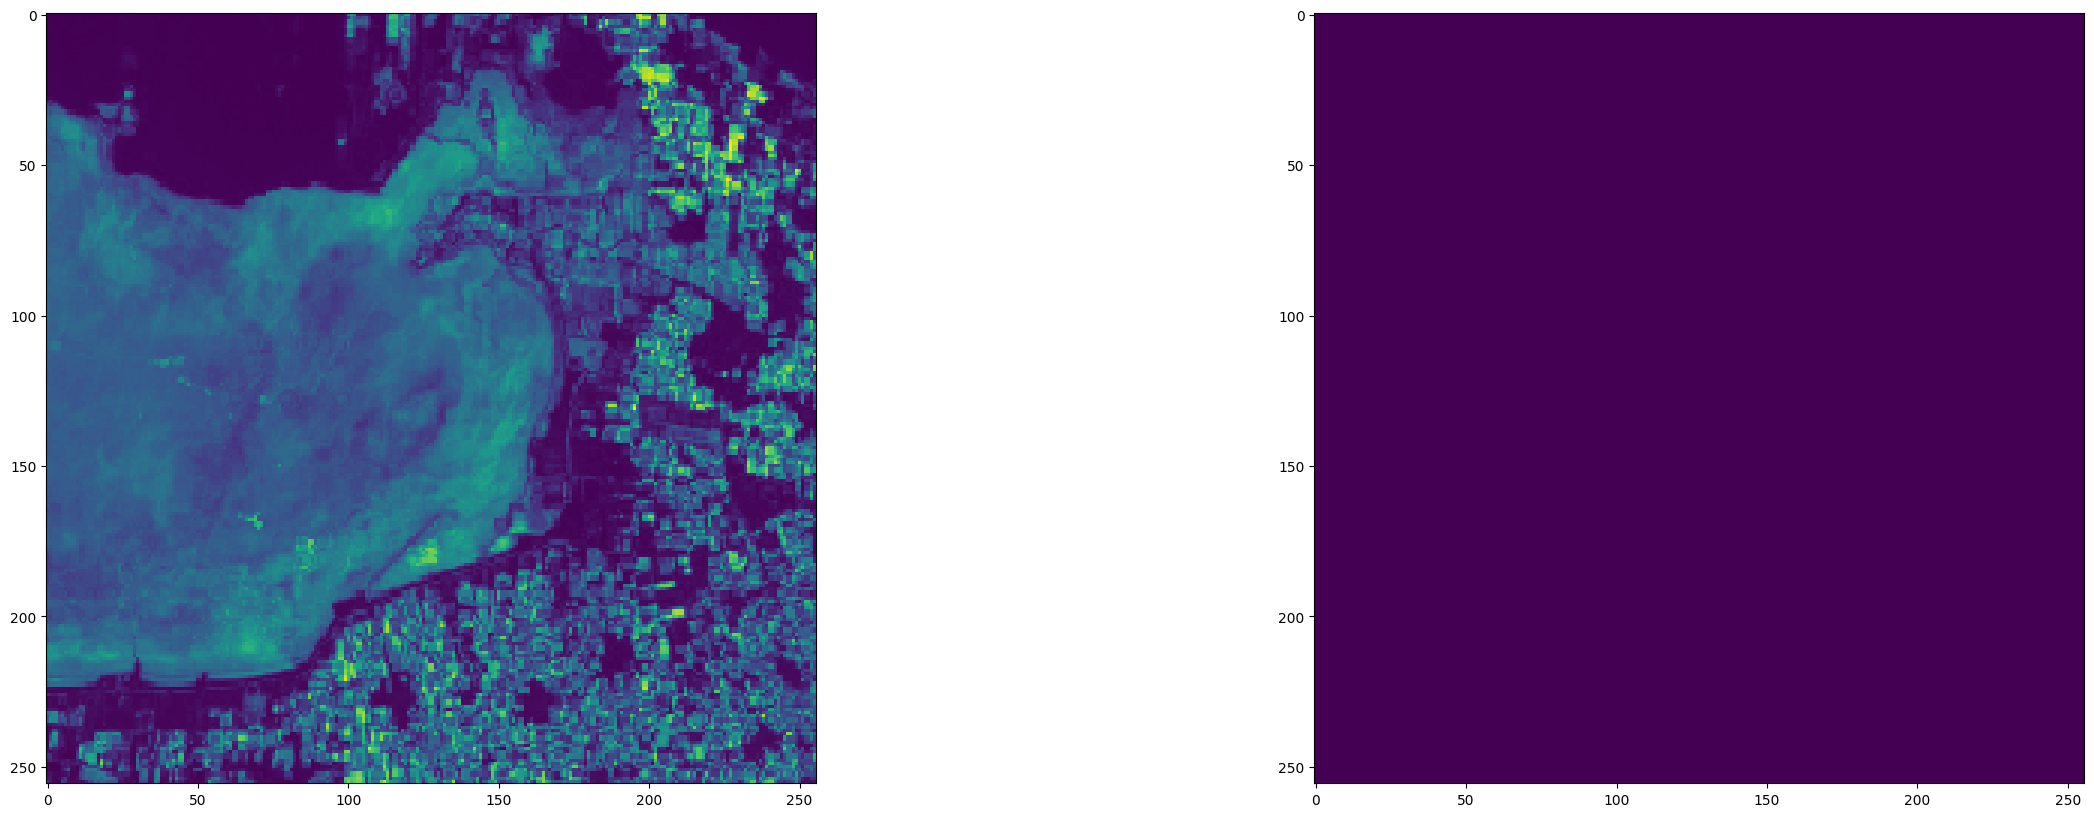

In [13]:
# Fisrt, let's checkout the STDEV of the NDVI values
# Because we need to use multiple STAC assets, it's easier to use the STACReader


def custom_tiler(asset, *args, **kwargs):
    with STACReader(asset) as stac:
        return stac.tile(*args, expression="(B08_b1-B04_b1)/(B08_b1+B04_b1)")


tile = tiles[0]

img, assets_used = mosaic_reader(
    stac_assets,
    custom_tiler,
    tile.x,
    tile.y,
    tile.z,
    pixel_selection=defaults.StdevMethod(),
)

fig = figure(figsize=(30, 10))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img.data_as_image())

ax = fig.add_subplot(1, 2, 2)
ax.imshow(img.mask)

In [14]:
print(len(assets_used))
print(assets_used)

23
['https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_36RTT_20190830_0_L2A', 'https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_36RTT_20190827_0_L2A', 'https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_36RTT_20190825_0_L2A', 'https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_36RTT_20190820_0_L2A', 'https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_36RTT_20190815_0_L2A', 'https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_36RTT_20190810_0_L2A', 'https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_36RTT_20190805_0_L2A', 'https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_36RTT_20190731_0_L2A', 'https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_36RTT_20190726_0_L2A', 'https://earth-

In [15]:
# We create a custom tiler function that will read the TCI asset and add a 4th representing the NDVI


def custom_tiler(asset, *args, **kwargs):
    with STACReader(asset) as stac:
        img = stac.tile(*args, assets="visual")
        ndvi = stac.tile(*args, expression="(B08_b1-B04_b1)/(B08_b1+B04_b1)")
        return ImageData(
            numpy.concatenate((img.data, ndvi.data)),
            img.mask,
            crs=img.crs,
            bounds=img.bounds,
        )

In [16]:
class CustomFourthBandH(MosaicMethodBase):
    """Feed the mosaic tile with the Mean pixel value."""

    @property
    def data(self):
        """Return data and mask."""
        if self.mosaic is not None:
            return self.mosaic[:-1].copy()

        return None

    def feed(self, array):
        """Add data to mosaic."""

        if self.mosaic is None:
            self.mosaic = array
            return

        pidex = (
            numpy.bitwise_and(array.data[-1] > self.mosaic.data[-1], ~array.mask)
            | self.mosaic.mask
        )

        mask = numpy.where(pidex, array.mask, self.mosaic.mask)
        self.mosaic = numpy.ma.where(pidex, array, self.mosaic)
        self.mosaic.mask = mask

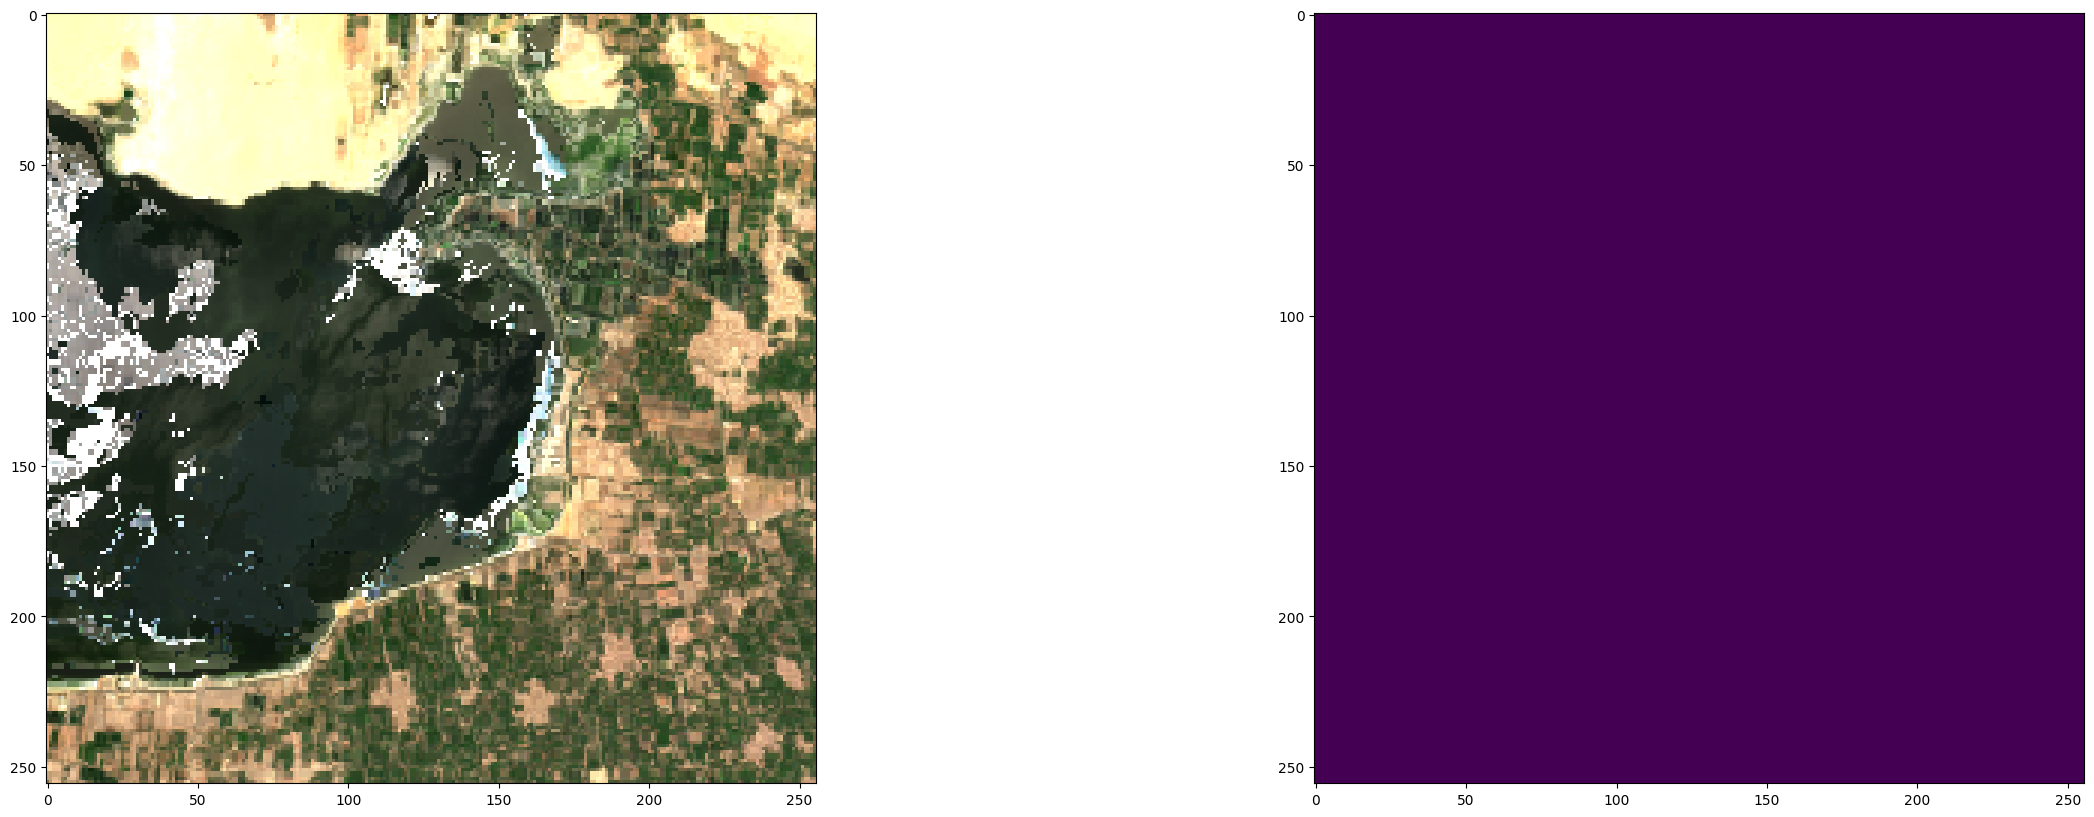

In [17]:
tile = tiles[0]

img, assets_used = mosaic_reader(
    stac_assets,
    custom_tiler,
    tile.x,
    tile.y,
    tile.z,
    pixel_selection=CustomFourthBandH(),
)

fig = figure(figsize=(30, 10))

ax = fig.add_subplot(1, 2, 1)

# NOTE: because we are using NDVI + Visual, the output array, will be in float32
ax.imshow(img.data_as_image().astype("uint8"))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(img.mask)

In [18]:
print(len(assets_used))
print(assets_used)

23
['https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_36RTT_20190830_0_L2A', 'https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_36RTT_20190827_0_L2A', 'https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_36RTT_20190825_0_L2A', 'https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_36RTT_20190820_0_L2A', 'https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_36RTT_20190815_0_L2A', 'https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_36RTT_20190810_0_L2A', 'https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_36RTT_20190805_0_L2A', 'https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_36RTT_20190731_0_L2A', 'https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_36RTT_20190726_0_L2A', 'https://earth-